In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

In [ ]:
pip install networkx

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_samples = 10000
embedding_dim = 64
k = 5

In [36]:
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
subset = Subset(mnist, range(n_samples))
loader = DataLoader(subset, batch_size=64)

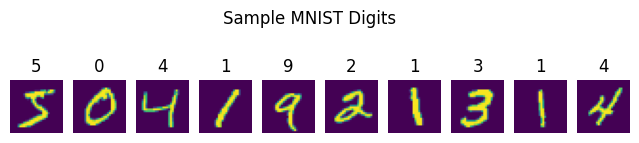

In [37]:
plt.figure(figsize=(8, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(mnist[i][0].squeeze())
    plt.axis('off')
    plt.title(mnist[i][1])
plt.suptitle("Sample MNIST Digits")
plt.show()

In [38]:
class CNN(nn.Module):
    def __init__(self, emb_dim=64):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, emb_dim),
            nn.ReLU()
        )
        self.classifier = nn.Linear(emb_dim, 10)

    def forward(self, x):
        emb = self.net(x)
        return self.classifier(emb), emb
    
cnn = CNN(embedding_dim).to(device)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [39]:
# Train CNN
print("Training CNN...")
cnn.train()
for epoch in range(10):
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out, _ = cnn(images)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Training CNN...
Epoch 1, Loss: 88.5267
Epoch 2, Loss: 25.9377
Epoch 3, Loss: 17.2482
Epoch 4, Loss: 12.9986
Epoch 5, Loss: 10.0999
Epoch 6, Loss: 8.0808
Epoch 7, Loss: 6.6869
Epoch 8, Loss: 5.1273
Epoch 9, Loss: 4.0272
Epoch 10, Loss: 3.4839


In [40]:
# Extract CNN Embeddings
print("Extracting embeddings...")
cnn.eval()
features, labels = [], []
images_for_plot = []
with torch.no_grad():
    for images, lbls in loader:
        images = images.to(device)
        _, emb = cnn(images)
        features.append(emb.cpu())
        labels.extend(lbls)
        images_for_plot.extend(images.cpu())

features = torch.cat(features)
labels = torch.tensor(labels)

print(features)
print(labels)

Extracting embeddings...
tensor([[ 0.0000,  8.8385,  0.0000,  ...,  0.0000, 11.1319,  7.9544],
        [ 0.0000,  0.0000,  0.0000,  ...,  4.2173, 11.7865,  0.0000],
        [ 0.0000,  2.1616,  0.0000,  ...,  0.0000,  0.3250,  0.0000],
        ...,
        [ 0.0000,  4.1764,  0.0000,  ...,  7.0685,  0.0000,  4.4904],
        [ 0.0000, 13.9538,  0.0000,  ...,  0.0000, 14.0082,  0.0000],
        [ 0.0000, 11.8800,  0.0000,  ...,  0.4748, 15.9679, 10.4400]])
tensor([5, 0, 4,  ..., 6, 9, 7])


Running t-SNE...


/Users/macbookpro/Documents/GNN_lab/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


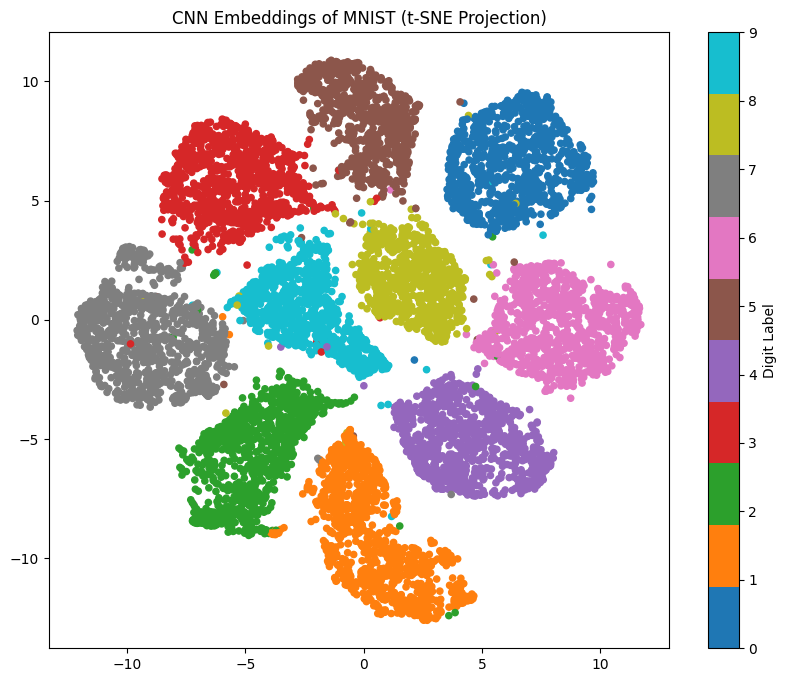

In [41]:
# t-SNE for Visualization
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embed = tsne.fit_transform(features)

# Visualize Embeddings in 2D
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embed[:, 0], tsne_embed[:, 1], c=labels, cmap='tab10', s=20)
plt.title("CNN Embeddings of MNIST (t-SNE Projection)")
plt.colorbar(label="Digit Label")
plt.show()

In [ ]:
#  Build KNN Graph
print("Building KNN graph...")
knn = NearestNeighbors(n_neighbors=k+1).fit(features)
_, indices = knn.kneighbors(features)




Building KNN graph...


In [28]:
# Create edge list
edge_index = []
for i in range(n_samples):
    for j in indices[i][1:]:
        edge_index.append([i, j])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()


In [29]:
# Prepare PyG Data Object
data = Data(
    x=features,
    edge_index=edge_index,
    y=labels
)

# Train/test split
idx = np.arange(n_samples)
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=labels)
data.train_mask = torch.zeros(n_samples, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask = torch.zeros(n_samples, dtype=torch.bool)
data.test_mask[test_idx] = True


In [30]:
# Define GNN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

gnn = GCN(embedding_dim, 64, 10).to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [32]:
# Train GNN
print("Training GNN...")
for epoch in range(100):
    gnn.train()
    out = gnn(data.x.to(device), data.edge_index.to(device))
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    gnn.eval()
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask].to(device)).sum().item()
    acc = correct / data.test_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d}, Loss: {loss.item():.4f}, Test Accuracy: {acc*100:.2f}%")


Training GNN...
Epoch  0, Loss: 0.1154, Test Accuracy: 95.50%
Epoch 10, Loss: 0.1121, Test Accuracy: 95.50%
Epoch 20, Loss: 0.1090, Test Accuracy: 95.50%
Epoch 30, Loss: 0.1060, Test Accuracy: 95.00%
Epoch 40, Loss: 0.1033, Test Accuracy: 95.00%
Epoch 50, Loss: 0.1008, Test Accuracy: 95.00%
Epoch 60, Loss: 0.0985, Test Accuracy: 94.50%
Epoch 70, Loss: 0.0964, Test Accuracy: 94.50%
Epoch 80, Loss: 0.0943, Test Accuracy: 94.50%
Epoch 90, Loss: 0.0922, Test Accuracy: 94.50%


In [33]:
gnn.eval()
out = gnn(data.x.to(device), data.edge_index.to(device))
pred = out.argmax(dim=1).cpu()
true = data.y

acc = pred[data.test_mask].eq(true[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")



✅ Final Test Accuracy: 95.00%


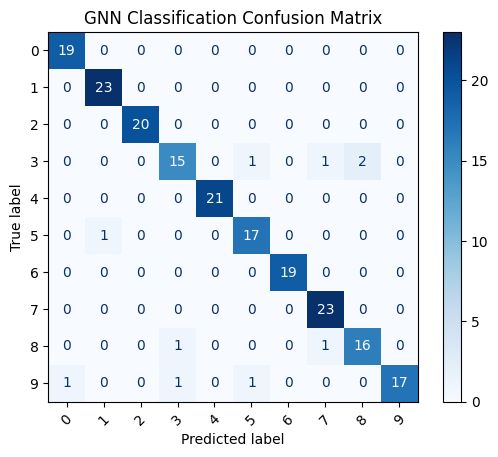

In [34]:

# Confusion Matrix
cm = confusion_matrix(true[data.test_mask], pred[data.test_mask])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("GNN Classification Confusion Matrix")
plt.show()

Visualizing KNN graph...


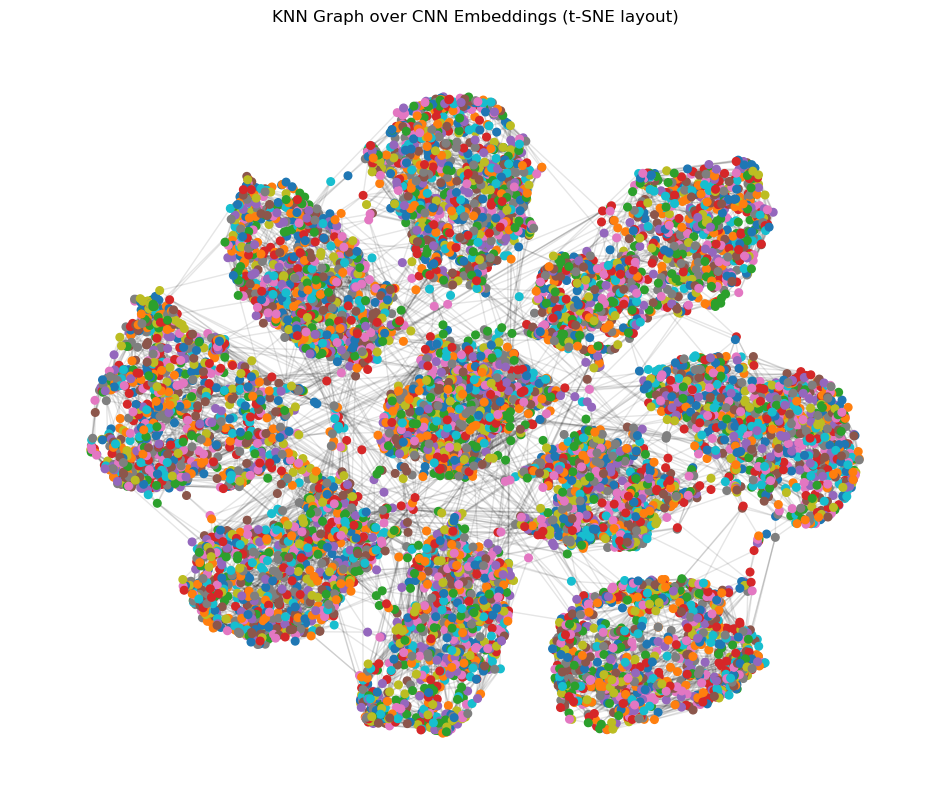

In [ ]:
# Visualize the KNN Graph (t-SNE layout)
print("Visualizing KNN graph...")
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())
pos = {i: tsne_embed[i] for i in range(n_samples)}

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.1)
nx.draw_networkx_nodes(G, pos, node_color=labels, cmap='tab10', node_size=30)
plt.title("KNN Graph over CNN Embeddings (t-SNE layout)")
plt.axis("off")
plt.show()
